In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
# Реализуем класс узла
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# Реализуем класс листа
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        if len(self.labels) == 0:
            return 0
        
        unique, counts = np.unique(self.labels, return_counts=True)
        return unique[np.argmax(counts)]

# Расчёт критерия Джини
def gini(labels):
    if len(labels) == 0:
        return 0
    
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    impurity = 1.0 - np.sum(probabilities ** 2)
    
    return impurity

# Расчёт качества разбиения
def quality(left_labels, right_labels, current_gini):
    p = float(len(left_labels)) / (len(left_labels) + len(right_labels))
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение выборки на две части
def split(data, labels, index, t):
    mask = data[:, index] <= t
    
    true_data = data[mask]
    false_data = data[~mask]
    true_labels = labels[mask]
    false_labels = labels[~mask]
    
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    # Минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = len(data[0]) if len(data) > 0 else 0
    
    for index in range(n_features):
        feature_values = sorted(set(data[:, index]))
        
        thresholds = []
        for i in range(len(feature_values) - 1):
            thresholds.append((feature_values[i] + feature_values[i + 1]) / 2)
        
        if not thresholds:
            continue
        
        for t in thresholds:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality = current_quality
                best_t = t
                best_index = index
    
    return best_quality, best_t, best_index

# Построение дерева посредством рекурсивной функции
def build_tree(data, labels, depth=0, max_depth=10):
    # Если достигли максимальной глубины или мало объектов
    if len(set(labels)) == 1 or len(labels) < 10 or depth >= max_depth:
        return Leaf(data, labels)
    
    # Находим лучшее разбиение
    best_quality, best_t, best_index = find_best_split(data, labels)
    
    # Разбиваем данные
    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)
    
    # Рекурсивно строим поддеревья
    true_branch = build_tree(true_data, true_labels, depth + 1, max_depth)
    false_branch = build_tree(false_data, false_labels, depth + 1, max_depth)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(best_index, best_t, true_branch, false_branch)

# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    # Если это лист, возвращаем предсказание
    if isinstance(node, Leaf):
        return node.prediction
    
    # Проверяем условие в узле
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# Предсказание деревом для всего датасета
def predict(data, tree):
    predictions = []
    for obj in data:
        predictions.append(classify_object(obj, tree))
    return np.array(predictions)


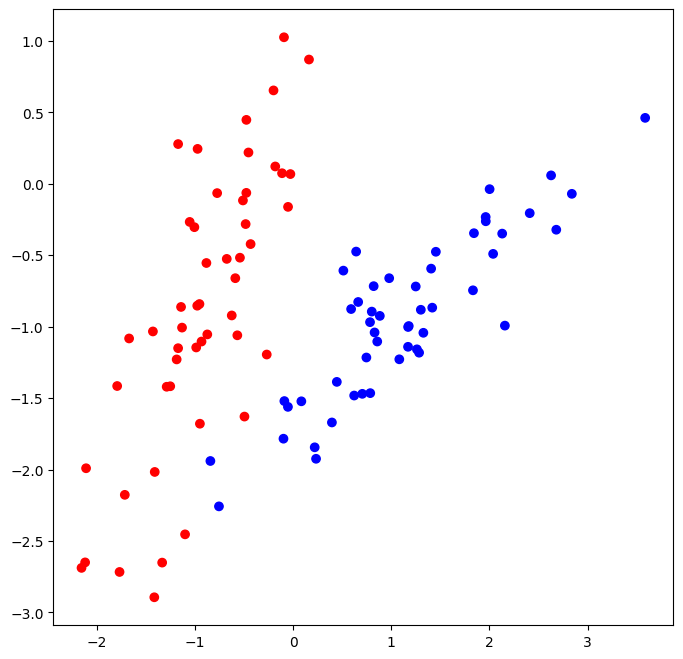

In [3]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

Индекс 0
Порог 0.19170657152269577
--> True:
  Индекс 1
  Порог -1.4690644971635907
  --> True:
    Индекс 0
    Порог -0.8945057940751789
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


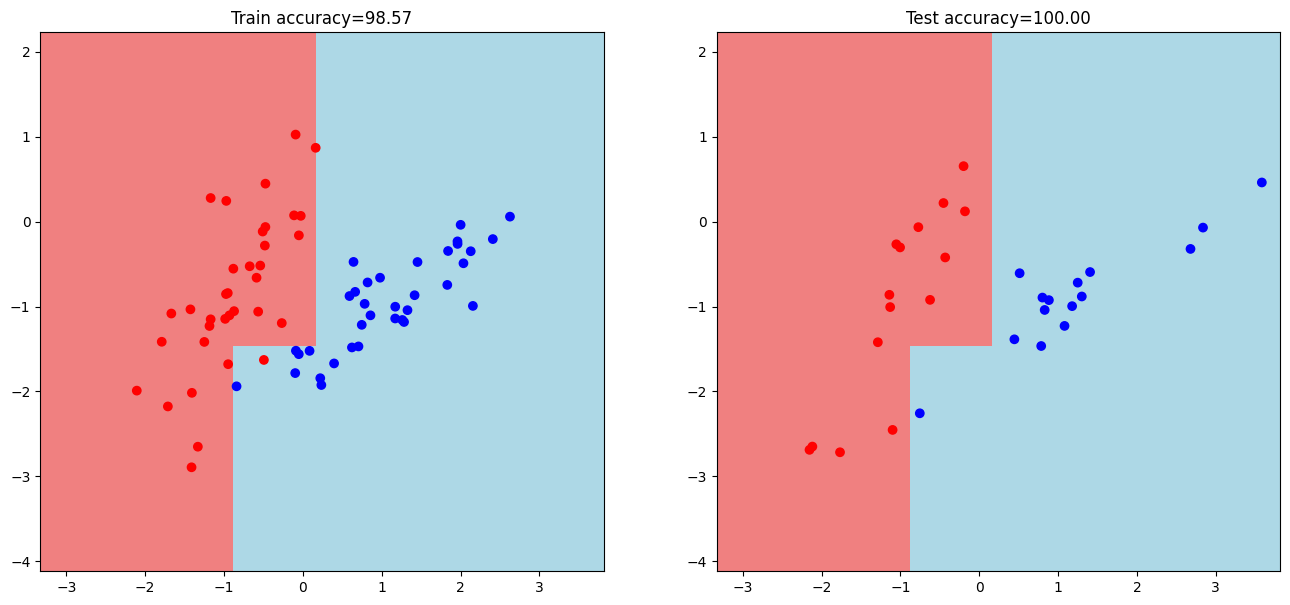

In [22]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)
     

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)
     

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)
     
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)
     

# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
     

# Введём функцию подсчёта точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
     

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy
     

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

#print(np.c_[xx.ravel(), yy.ravel()])

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()
